## CIS 635 Project

### Leveraging Data Mining to Understand and Predict Airbnb Listing Prices

#### Loading required libraries

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew

#### Downloading data from kaggle website

The data we are using for this project is hosted in kaggle. [U.S. Airbnb Open Data](https://www.kaggle.com/datasets/kritikseth/us-airbnb-open-data)

#### Downloading datasets in csv format

In [2]:
#Path to the dataset
path = kagglehub.dataset_download("kritikseth/us-airbnb-open-data")

100%|██████████| 22.9M/22.9M [00:00<00:00, 96.0MB/s]

Extracting files...


In [3]:
#Connecting to files in path
csv_path1 = os.path.join(path, "AB_US_2020.csv")
csv_path2 = os.path.join(path, "AB_US_2023.csv")
#Load the data from CSV files
df1 = pd.read_csv(csv_path1)
df2 = pd.read_csv(csv_path2)
#Previewing the two datasets
print(df1.describe())
print(df2.describe())

/tmp/ipython-input-798040142.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(csv_path1)
/tmp/ipython-input-798040142.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(csv_path2)


                 id       host_id       latitude      longitude  \
count  2.260300e+05  2.260300e+05  226030.000000  226030.000000   
mean   2.547176e+07  9.352385e+07      35.662829    -103.220662   
std    1.317814e+07  9.827422e+07       6.849855      26.222091   
min    1.090000e+02  2.300000e+01      18.920990    -159.714900   
25%    1.515890e+07  1.399275e+07      32.761783    -118.598115   
50%    2.590916e+07  5.138266e+07      37.261125     -97.817200   
75%    3.772624e+07  1.497179e+08      40.724038     -76.919323   
max    4.556085e+07  3.679176e+08      47.734620     -70.995950   

               price  minimum_nights  number_of_reviews  reviews_per_month  \
count  226030.000000    2.260300e+05      226030.000000       177428.00000   
mean      219.716529    4.525490e+02          34.506530            1.43145   
std       570.353609    2.103376e+05          63.602914            1.68321   
min         0.000000    1.000000e+00           0.000000            0.01000   
25%   

In [4]:
#checking the length of columns in df1 and df2
print(f'Columns in df1 = {len(df1.columns)}')
print(f'Columns in df2 = {len(df2.columns)}')

Columns in df1 = 17
Columns in df2 = 18


In [5]:
#Selecting columns common in both df1 and df2 before concatenating the dataframes
df1_cols = set(df1.columns)
df2_cols = set(df2.columns)

#Common columns
common = df1_cols & df2_cols
unique_to_df2 = df2_cols - df1_cols
print("Common columns:", common)
print("Columns unique to df2:", unique_to_df2)

Common columns: {'last_review', 'reviews_per_month', 'id', 'minimum_nights', 'longitude', 'calculated_host_listings_count', 'availability_365', 'price', 'name', 'neighbourhood_group', 'host_name', 'host_id', 'room_type', 'neighbourhood', 'latitude', 'city', 'number_of_reviews'}
Columns unique to df2: {'number_of_reviews_ltm'}


In [6]:
# Finding unique columns in df1 (columns that are in df1 but not in df2)
unique_df1 = df1_cols - df2_cols
print("\nColumns unique to df1:", unique_df1)
# Finding unique columns in df2 (columns that are in df2 but not in df1)
unique_df2 = df2_cols - df1_cols
print("\nColumns unique to df2:", unique_df2)


Columns unique to df1: set()

Columns unique to df2: {'number_of_reviews_ltm'}


In [7]:
#selecting only common columns in df2 to merge df1.
df2 = df2[list(common)]
len(df2.columns)

17

In [8]:
#concatenating df1 and df2
joined_df = pd.concat([df1, df2], axis=0, ignore_index=True)
merged_df = joined_df.copy()

In [9]:
joined_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [10]:
joined_df.shape

(458177, 17)

The dataframe consists of 458177 entries and 17 variables.

In [11]:
#Checking the data types of various variables in the dataframe.
print(joined_df.info(show_counts=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458177 entries, 0 to 458176
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   id                              int64  
 1   name                            object 
 2   host_id                         int64  
 3   host_name                       object 
 4   neighbourhood_group             object 
 5   neighbourhood                   object 
 6   latitude                        float64
 7   longitude                       float64
 8   room_type                       object 
 9   price                           int64  
 10  minimum_nights                  int64  
 11  number_of_reviews               int64  
 12  last_review                     object 
 13  reviews_per_month               float64
 14  calculated_host_listings_count  int64  
 15  availability_365                int64  
 16  city                            object 
dtypes: float64(3), int64(7), obje

#### Checking the number of missing values for every column in joined df

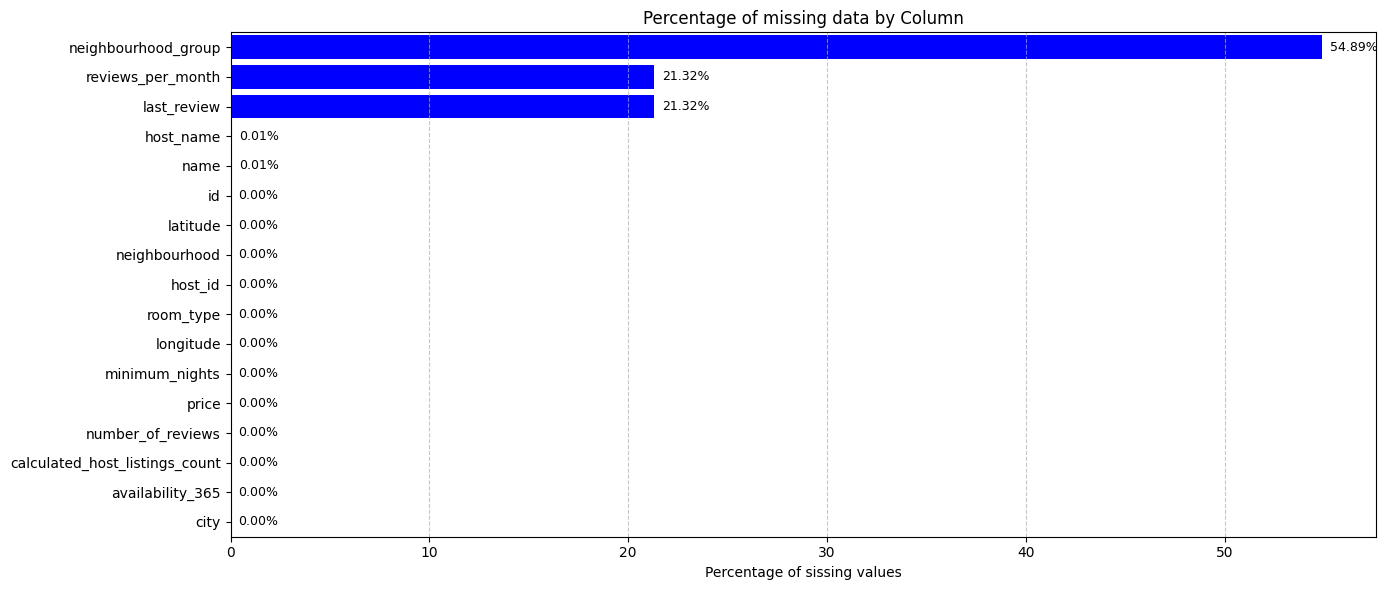

In [12]:
missing_counts = joined_df.isnull().sum()
missing_df = pd.DataFrame({'column': missing_counts.index,
                           'missing_percent': (missing_counts.values/len(joined_df))*100
                           })
missing_df = missing_df.sort_values(by='missing_percent', ascending=False)
plt.figure(figsize=(14, 6))
bars = plt.barh(missing_df['column'], missing_df['missing_percent'], color='blue')
plt.ylim(-0.5, len(missing_df['column']) - 0.5)
plt.xlabel('Percentage of sissing values')
plt.title('Percentage of missing data by Column')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
for bar, percent in zip(bars, missing_df['missing_percent']):
    plt.text(percent + 0.4, bar.get_y() + bar.get_height()/2,
             f'{percent:.2f}%', va='center', fontsize=9)
plt.tight_layout()
plt.show()

Neighbourhood_group variable has the highest number of missing values at 54.89% of the total entries for neighbourhood_group. Reviews_per_month and last_review both have 21.32% of missing values. host_name and name have 0.01% of missing values which is negligible.

In [13]:
# Drop 'neighbourhood_group' from cleaned_df
cleaned_df = joined_df.drop(columns=['neighbourhood_group'], errors='ignore')
cleaned_df.shape

(458177, 16)

The consequences of dropping missign values from the dataframe results to a reduction of the number of entries from 450,000 plus to 157742. What other ways do you suggest we consider?

Considered including ID, longitude and latitude however, we can exclude since they are not continuous and it isn't very meaningful to have their summary statistics

In [14]:
# Checking for duplicates in the cleaned_df
duplicate_rows = cleaned_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 290


There are 290 duplicate rows in the data set

In [15]:
# Removing duplicates
cleaned_df = cleaned_df.drop_duplicates()

In [16]:
# Summary statistics for numerical columns in the cleaned_df
print(cleaned_df.select_dtypes(include=['number']).describe().T)

                                   count          mean           std  \
id                              457887.0  1.310373e+17  2.785723e+17   
host_id                         457887.0  1.263664e+08  1.363076e+08   
latitude                        457887.0  3.614498e+01  6.057847e+00   
longitude                       457887.0 -1.007265e+02  2.328611e+01   
price                           457887.0  2.398194e+02  8.325533e+02   
minimum_nights                  457887.0  2.302277e+02  1.477817e+05   
number_of_reviews               457887.0  3.777757e+01  7.282810e+01   
reviews_per_month               360490.0  1.536516e+00  1.805348e+00   
calculated_host_listings_count  457887.0  2.339092e+01  8.383689e+01   
availability_365                457887.0  1.703980e+02  1.378415e+02   

                                      min           25%           50%  \
id                                6.00000  1.908486e+07  3.455975e+07   
host_id                          23.00000  1.800776e+07  6.99

In [17]:
# Combined check of data type, unique values and missingness per column
print("Data Type, Unique Values, and Missingness")
data_summary = pd.DataFrame({
    'dtype': cleaned_df.dtypes,
    'unique_values': cleaned_df.nunique(),
    'missing_percent': cleaned_df.isnull().mean() * 100
}).sort_values(by='missing_percent', ascending=False)

print(data_summary, "\n")

Data Type, Unique Values, and Missingness
                                  dtype  unique_values  missing_percent
reviews_per_month               float64           1476        21.270969
last_review                      object           5524        21.270969
host_name                        object          42550         0.009828
name                             object         375684         0.009609
neighbourhood                    object           1459         0.000000
latitude                        float64         244267         0.000000
id                                int64         370252         0.000000
host_id                           int64         188040         0.000000
room_type                        object              4         0.000000
longitude                       float64         250621         0.000000
minimum_nights                    int64            202         0.000000
price                             int64           2773         0.000000
number_of_reviews     

review_per_month and last_review have the highest missingness at 21.261699 percent.

In [18]:
cleaned_df = cleaned_df.dropna(subset=['reviews_per_month', 'last_review'])


In [19]:
# Select numeric columns (exclude IDs and coordinates)
numeric_cols_for_skew = cleaned_df.select_dtypes(include=['number']).drop(columns=['id','host_id','latitude','longitude'], errors='ignore')

# Compute skewness
skew_values = numeric_cols_for_skew.apply(skew).sort_values(ascending=False)
print(skew_values)


minimum_nights                    600.405676
price                              87.508607
calculated_host_listings_count     10.022808
reviews_per_month                   4.811511
number_of_reviews                   3.810668
availability_365                    0.135815
dtype: float64


The skewness results show that most numeric features in the dataset are highly right-skewed, particularly price, minimum_nights, and calculated_host_listings_count, indicating the presence of extreme high values or outliers, while availability_365 is nearly symmetric.

In [20]:
min_price_cut = 10
max_price_cut = 1000
cleaned_df = cleaned_df[(cleaned_df['price'] >= min_price_cut) & (cleaned_df['price'] <= max_price_cut)]


In [21]:
cleaned_df = cleaned_df[cleaned_df['minimum_nights'] != 100000000].copy()

Logical Consistency checks

In [22]:
# Checking for the logical consistency of the variables for reasonable ranges
print("Logical Consistency Checks")
# Checking price validity
if 'price' in cleaned_df.columns:
    invalid_prices = cleaned_df[cleaned_df['price'] <= 0]
    print(f"Listings with invalid price values (<=0): {len(invalid_prices)}")

# Range checks for the other variables
# Check ranges for numeric variables
num_cols = cleaned_df.select_dtypes(include=['number']).drop(
    columns=['id','price','host_id','latitude','longitude'], errors='ignore'
)
for col in num_cols.columns:
    print(f"{col} range: {num_cols[col].min()} - {num_cols[col].max()}")


Logical Consistency Checks
Listings with invalid price values (<=0): 0
minimum_nights range: 1 - 1250
number_of_reviews range: 1 - 3091
reviews_per_month range: 0.01 - 101.42
calculated_host_listings_count range: 1 - 1003
availability_365 range: 0 - 365


Shape after Modified Z-score filtering: (339407, 16)


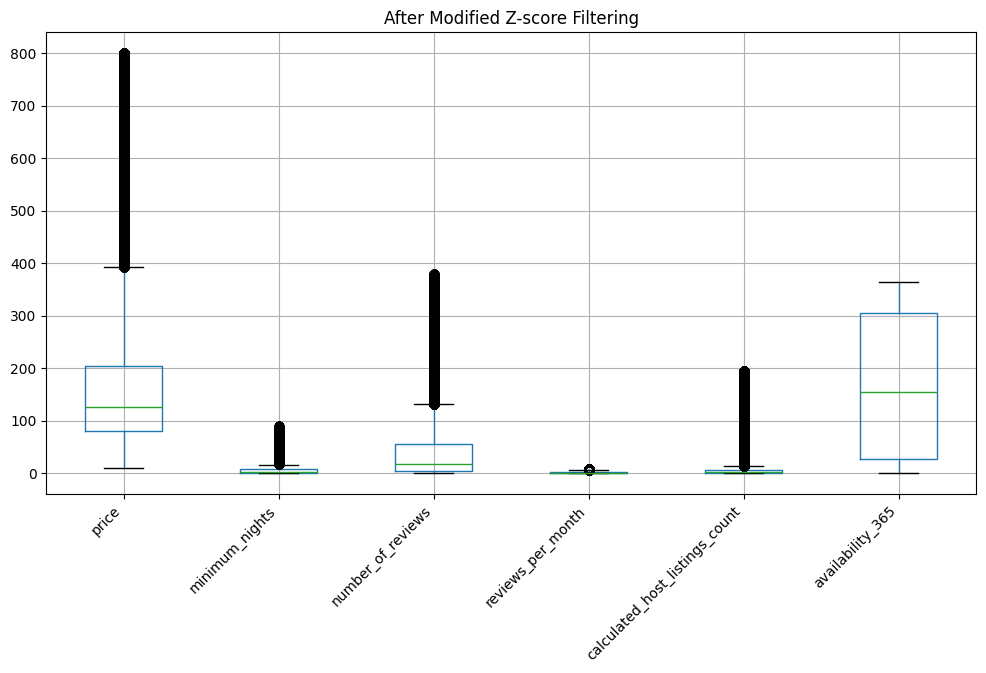

Final dataset shape after Modified Z-score + IQR filtering: (178768, 16)


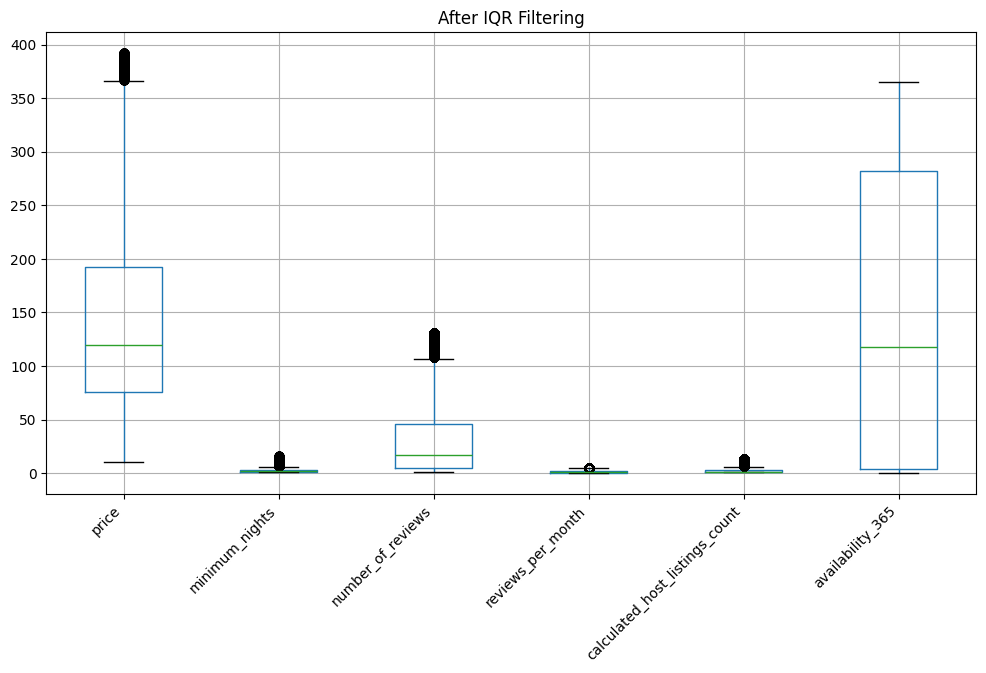

In [23]:
import matplotlib.pyplot as plt

# Select numeric columns (excluding IDs and coordinates)
num_cols = cleaned_df.select_dtypes(include=['number']).drop(
    columns=['id','host_id','latitude','longitude'], errors='ignore'
)

# 1. Modified Z-score outlier removal
medians = num_cols.median()
mad = num_cols.apply(lambda x: np.median(np.abs(x - np.median(x))), axis=0)
mod_z_scores = 0.6745 * (num_cols - medians) / mad
z_mask = (mod_z_scores.abs() <= mod_z_scores.abs().quantile(0.99)).all(axis=1)
cleaned_df_dynamic = cleaned_df.loc[z_mask].copy()
print(f"Shape after Modified Z-score filtering: {cleaned_df_dynamic.shape}")

# Plot after Modified Z-score filtering
plt.figure(figsize=(12,6))
cleaned_df_dynamic[num_cols.columns].boxplot()
plt.xticks(rotation=45, ha='right')
plt.title("After Modified Z-score Filtering")
plt.show()


# 2. IQR-based row-wise outlier removal
numeric_cols_dynamic = cleaned_df_dynamic.select_dtypes(include=['number']).drop(
    columns=['id','host_id','latitude','longitude'], errors='ignore'
)
iqr_factor = 1.5
iqr_mask = np.ones(len(cleaned_df_dynamic), dtype=bool)
for col in numeric_cols_dynamic.columns:
    Q1 = numeric_cols_dynamic[col].quantile(0.25)
    Q3 = numeric_cols_dynamic[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - iqr_factor * IQR
    upper = Q3 + iqr_factor * IQR
    iqr_mask &= (numeric_cols_dynamic[col] >= lower) & (numeric_cols_dynamic[col] <= upper)

cleaned_df_final = cleaned_df_dynamic.loc[iqr_mask].copy()
print(f"Final dataset shape after Modified Z-score + IQR filtering: {cleaned_df_final.shape}")

# Plot after IQR filtering
plt.figure(figsize=(12,6))
cleaned_df_final[num_cols.columns].boxplot()
plt.xticks(rotation=45, ha='right')
plt.title("After IQR Filtering")
plt.show()


Correlation Analysis

In [24]:
corr_matrix = numeric_cols_dynamic.corr()
display(corr_matrix.style.background_gradient(cmap='coolwarm').format("{:.2f}"))

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
price,1.00,-0.11,-0.07,-0.06,0.09,0.12
minimum_nights,-0.11,1.00,-0.14,-0.31,0.02,0.01
number_of_reviews,-0.07,-0.14,1.00,0.64,-0.11,0.03
reviews_per_month,-0.06,-0.31,0.64,1.00,-0.08,0.07
calculated_host_listings_count,0.09,0.02,-0.11,-0.08,1.00,0.16
availability_365,0.12,0.01,0.03,0.07,0.16,1.00


Most numeric features are weakly correlated, with the only moderate relationship being between number_of_reviews and reviews_per_month, while all other variables vary largely and independently.

In [25]:
# Compute City Centroids
city_centroids = cleaned_df_final.groupby('city')[['latitude','longitude']].mean().rename(
    columns={'latitude':'centroid_lat','longitude':'centroid_lon'}
).reset_index()
cleaned_df_final = cleaned_df_final.merge(city_centroids, on='city', how='left')

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians,[lat1,lon1,lat2,lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

cleaned_df_final['l2_distance_km'] = haversine_km(
    cleaned_df_final['latitude'], cleaned_df_final['longitude'],
    cleaned_df_final['centroid_lat'], cleaned_df_final['centroid_lon']
)

Data Visualization

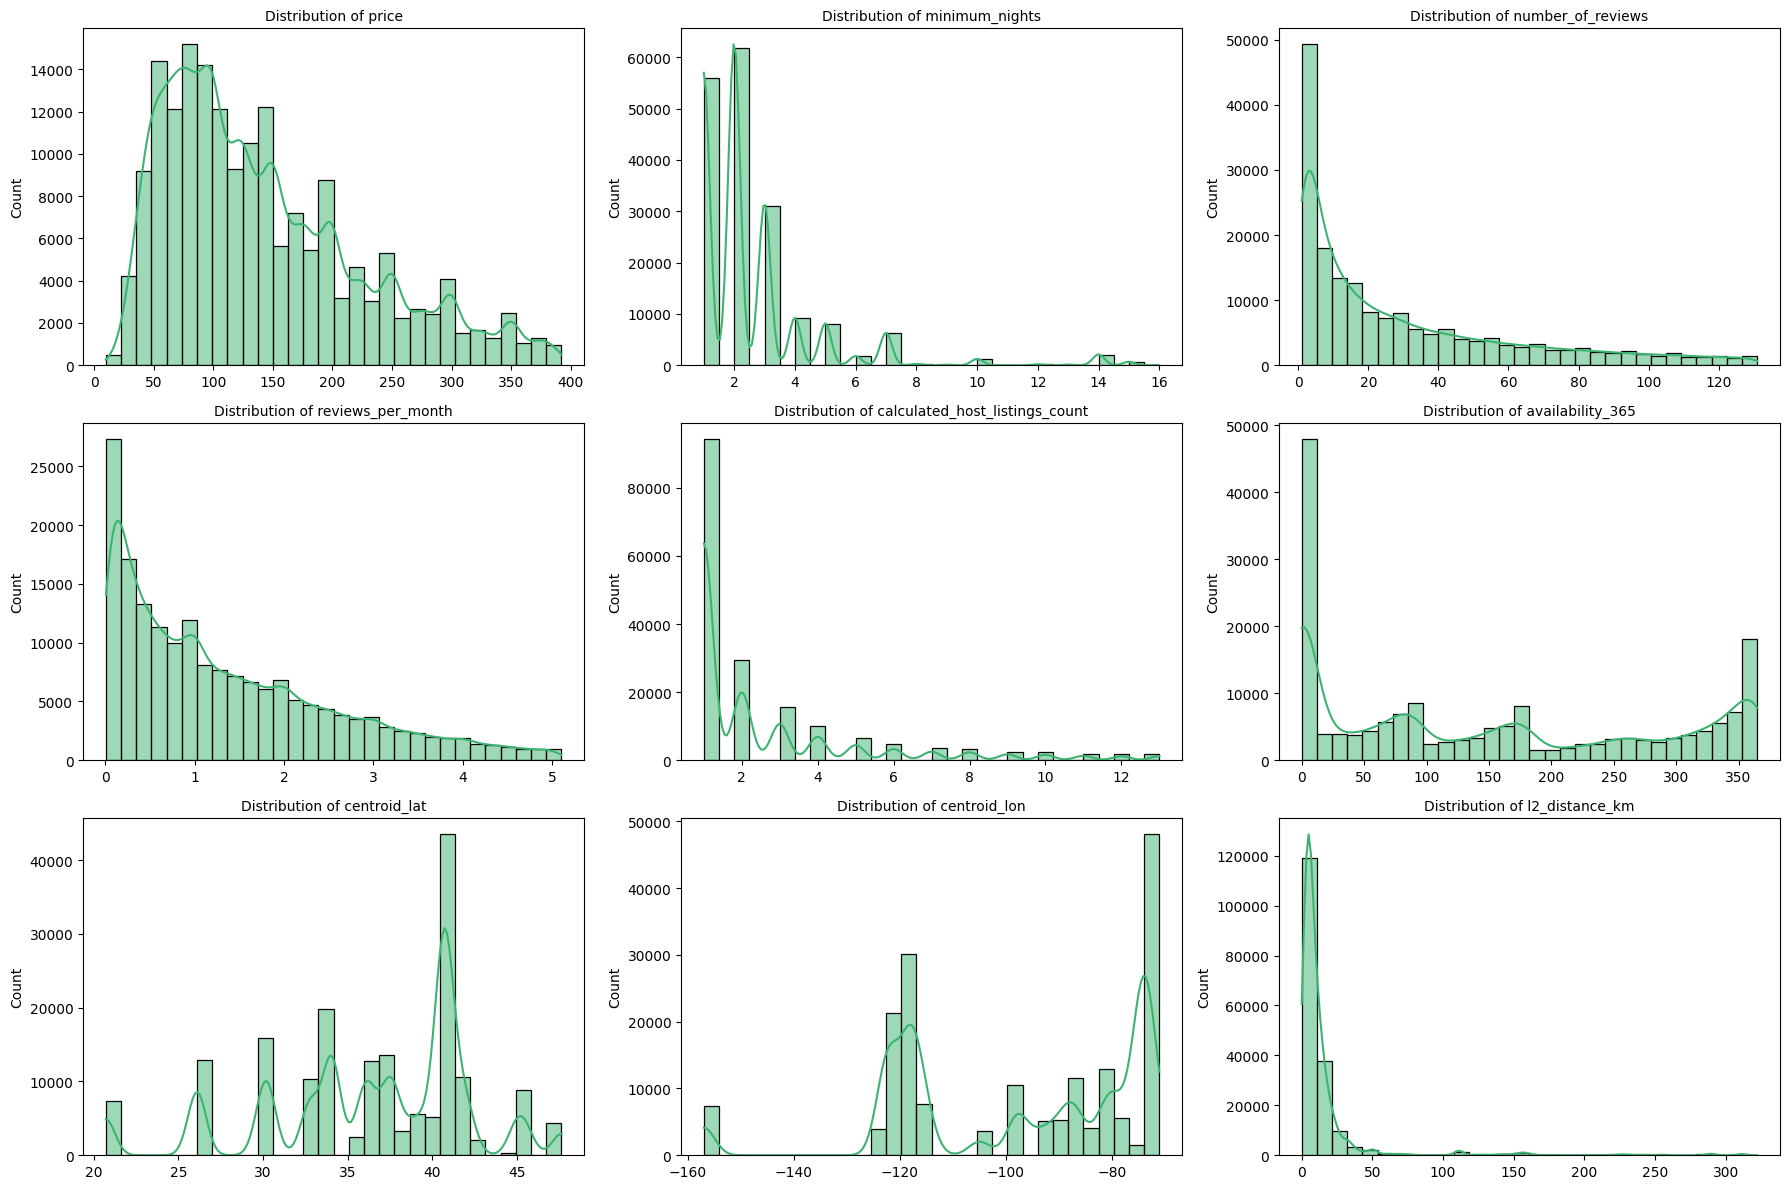

In [26]:
# Visualizing Distributions
numeric_cols_final = cleaned_df_final.select_dtypes(include=['number']).drop(
    columns=['id','host_id','latitude','longitude'], errors='ignore'
)

plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_cols_final.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(cleaned_df_final[col], kde=True, bins=30, color='mediumseagreen')
    plt.title(f'Distribution of {col}', fontsize=10)
    plt.xlabel('')
plt.tight_layout()
plt.show()


log transformation

In [27]:
skewed_cols = numeric_cols_final.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
high_skew = skewed_cols[abs(skewed_cols) > 1].index
for col in high_skew:
    cleaned_df_final[col] = cleaned_df_final[col].apply(lambda x: np.log1p(x))

print(f"Applied log1p transformation to highly skewed columns: {list(high_skew)}")

Applied log1p transformation to highly skewed columns: ['l2_distance_km', 'minimum_nights', 'calculated_host_listings_count', 'number_of_reviews']


Data Scaling and Feature engineering

In [28]:
cleaned_df_final['minimum_nights'].describe()

,minimum_nights
count,178768.000000
mean,1.161084
std,0.444232
min,0.693147
25%,0.693147
50%,1.098612
75%,1.386294
max,2.833213


In [29]:
cleaned_df_final['price'].describe()

,price
count,178768.000000
mean,142.245659
std,84.114251
min,10.000000
25%,76.000000
50%,120.000000
75%,192.000000
max,392.000000


In [30]:
cleaned_df_final['availability_365'].describe()

,availability_365
count,178768.000000
mean,148.779301
std,133.737940
min,0.000000
25%,4.000000
50%,118.000000
75%,282.000000
max,365.000000


In [53]:
# Price discretization: low, medium, high based on quantiles
p1, p2 = cleaned_df_final['price'].quantile([0.33, 0.66])
def price_bucket(p):
    if p <= p1:
        return 'low'
    elif p <= p2:
        return 'medium'
    else:
        return 'high'

cleaned_df_final['price_bucket'] = cleaned_df_final['price'].apply(price_bucket)

# Availability categorization
def availability_bucket(a):
    if a == 0:
        return 'Not available'
    elif a <= 90:
        return 'low'
    elif a <= 180:
        return 'medium'
    else:
        return 'high'

cleaned_df_final['availability_bucket'] = cleaned_df_final['availability_365'].apply(availability_bucket)

# Minimum nights
mn1, mn2 = cleaned_df_final['minimum_nights'].quantile([0.33, 0.66])
def minimum_nights_bucket(n):
    if n <= mn1:
        return 'short'
    elif n <= mn2:
        return 'medium'
    else:
        return 'long'

cleaned_df_final['minimum_nights_bucket'] = cleaned_df_final['minimum_nights'].apply(minimum_nights_bucket)

# Discretize distance into Urban/Suburban/Rural
q1, q2 = cleaned_df_final['l2_distance_km'].quantile([0.33, 0.66])

def area_category_km(d):
    if d <= q1:
        return 'urban'
    elif d <= q2:
        return 'suburban'
    else:
        return 'rural'

cleaned_df_final['area_category'] = cleaned_df_final['l2_distance_km'].apply(area_category_km)


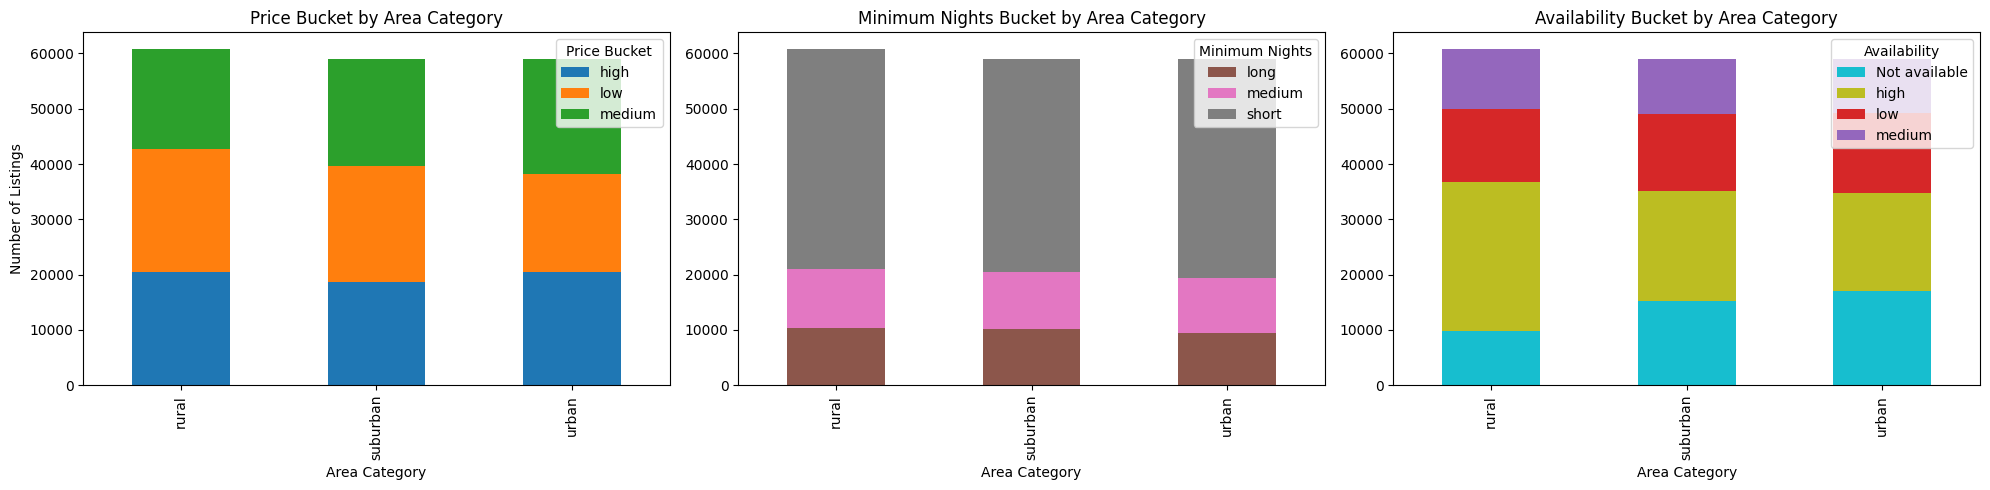

In [57]:
# Define colors for each category in each plot
price_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
nights_colors = ['#8c564b', '#e377c2', '#7f7f7f']
availability_colors = ['#17becf', '#bcbd22', '#d62728', '#9467bd']

# Set up 1-row, 3-column grid
fig, axes = plt.subplots(1, 3, figsize=(20,5))

# 1. Price Bucket by Area Category
price_data = cleaned_df_final.groupby(['area_category','price_bucket']).size().unstack(fill_value=0)
price_data.plot(kind='bar', stacked=True, color=price_colors, ax=axes[0])
axes[0].set_title("Price Bucket by Area Category")
axes[0].set_xlabel("Area Category")
axes[0].set_ylabel("Number of Listings")
axes[0].legend(title='Price Bucket', loc='upper right')

# 2. Minimum Nights Bucket by Area Category
nights_data = cleaned_df_final.groupby(['area_category','minimum_nights_bucket']).size().unstack(fill_value=0)
nights_data.plot(kind='bar', stacked=True, color=nights_colors, ax=axes[1])
axes[1].set_title("Minimum Nights Bucket by Area Category")
axes[1].set_xlabel("Area Category")
axes[1].set_ylabel("")
axes[1].legend(title='Minimum Nights', loc='upper right')

# 3. Availability Bucket by Area Category
availability_data = cleaned_df_final.groupby(['area_category','availability_bucket']).size().unstack(fill_value=0)
availability_data.plot(kind='bar', stacked=True, color=availability_colors, ax=axes[2])
axes[2].set_title("Availability Bucket by Area Category")
axes[2].set_xlabel("Area Category")
axes[2].set_ylabel("")
axes[2].legend(title='Availability', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

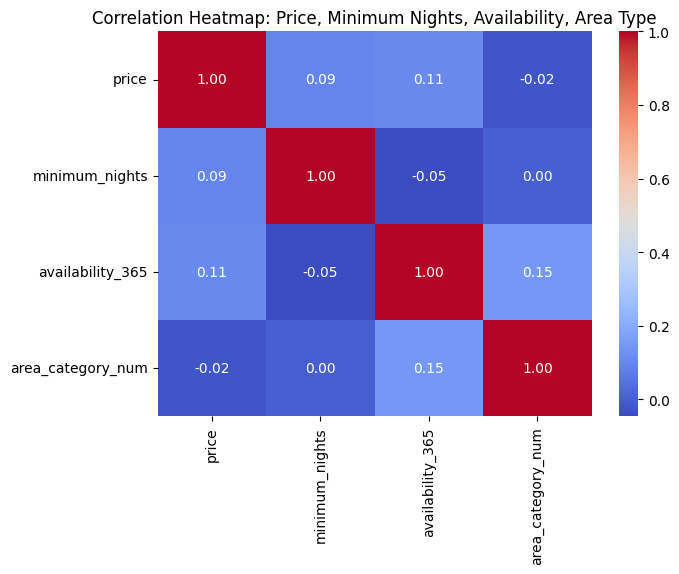

In [56]:
# Encode area_category numerically
area_mapping = {'urban': 0, 'suburban': 1, 'rural': 2}
cleaned_df_final['area_category_num'] = cleaned_df_final['area_category'].map(area_mapping)

# Select columns for correlation
selected_cols = ['price', 'minimum_nights', 'availability_365', 'area_category_num']

plt.figure(figsize=(7, 5))
sns.heatmap(
    cleaned_df_final[selected_cols].corr(),
    annot=True, fmt=".2f",
    cmap='coolwarm', cbar=True
)
plt.title("Correlation Heatmap: Price, Minimum Nights, Availability, Area Type", fontsize=12)
plt.show()

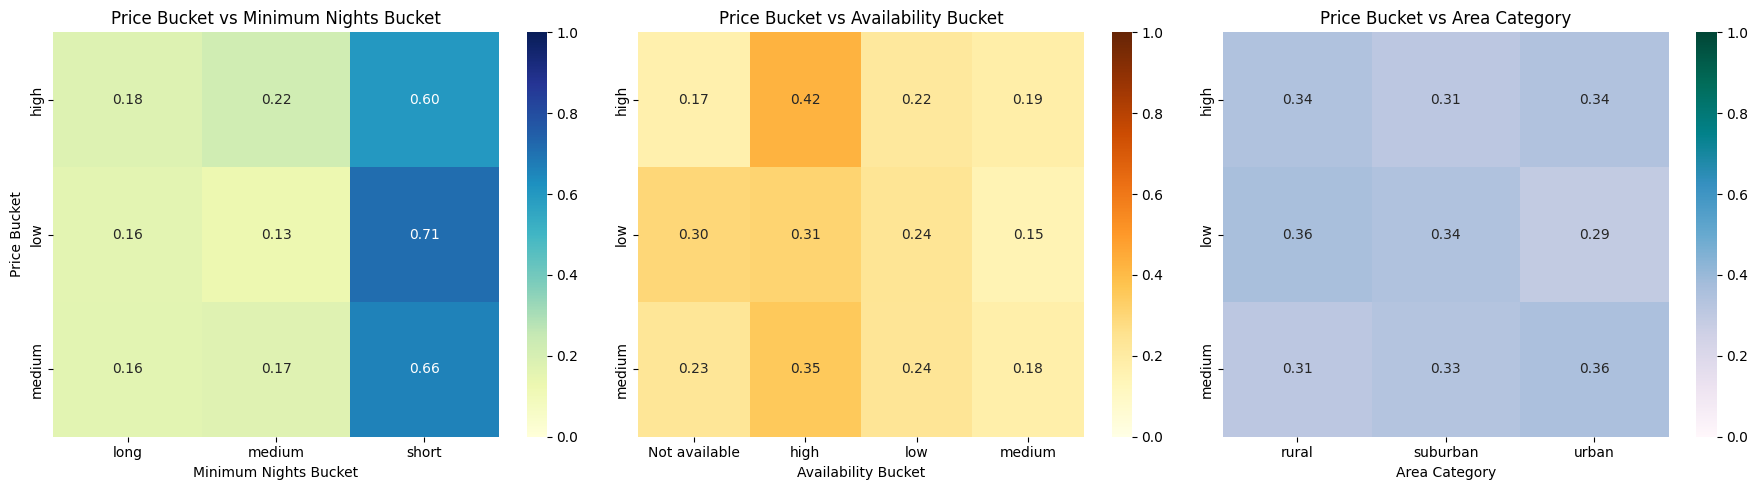

In [55]:
# Convert crosstabs to proportional (0–1) "correlation-like" format
ct1 = pd.crosstab(
    cleaned_df_final['price_bucket'],
    cleaned_df_final['minimum_nights_bucket'],
    normalize='index'
)

ct2 = pd.crosstab(
    cleaned_df_final['price_bucket'],
    cleaned_df_final['availability_bucket'],
    normalize='index'
)

ct3 = pd.crosstab(
    cleaned_df_final['price_bucket'],
    cleaned_df_final['area_category'],
    normalize='index'
)

# Create 1x3 grid for the three heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Price vs Minimum Nights (0–1 scale)
sns.heatmap(
    ct1, annot=True, fmt='.2f', cmap='YlGnBu', ax=axes[0],
    vmin=0, vmax=1
)
axes[0].set_title('Price Bucket vs Minimum Nights Bucket')
axes[0].set_xlabel('Minimum Nights Bucket')
axes[0].set_ylabel('Price Bucket')

# 2. Price vs Availability (0–1 scale)
sns.heatmap(
    ct2, annot=True, fmt='.2f', cmap='YlOrBr', ax=axes[1],
    vmin=0, vmax=1
)
axes[1].set_title('Price Bucket vs Availability Bucket')
axes[1].set_xlabel('Availability Bucket')
axes[1].set_ylabel('')

# 3. Price vs Area Category (0–1 scale)
sns.heatmap(
    ct3, annot=True, fmt='.2f', cmap='PuBuGn', ax=axes[2],
    vmin=0, vmax=1
)
axes[2].set_title('Price Bucket vs Area Category')
axes[2].set_xlabel('Area Category')
axes[2].set_ylabel('')

# Adjust layout and show
plt.tight_layout()
plt.show()

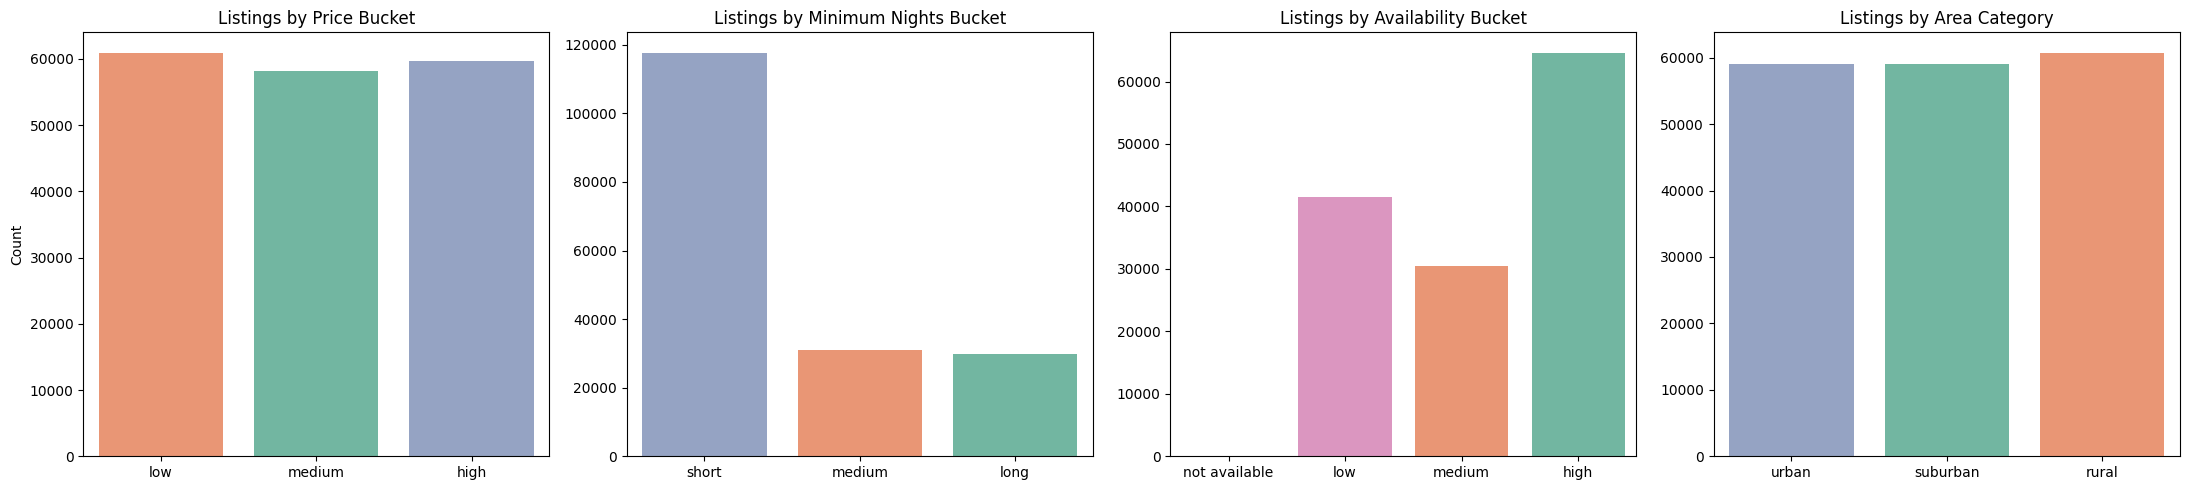

In [54]:
# Set up a 1-row, 4-column grid
fig, axes = plt.subplots(1, 4, figsize=(22, 5))  # Wider to fit 4 plots

# 1. Price bucket plot
sns.countplot(
    data=cleaned_df_final,
    x='price_bucket',
    hue='price_bucket',
    palette='Set2',
    order=['low', 'medium', 'high'],
    legend=False,
    ax=axes[0]
)
axes[0].set_title('Listings by Price Bucket')
axes[0].set_xlabel('')
axes[0].set_ylabel('Count')

# 2. Minimum nights bucket plot
sns.countplot(
    data=cleaned_df_final,
    x='minimum_nights_bucket',
    hue='minimum_nights_bucket',
    palette='Set2',
    order=['short', 'medium', 'long'],
    legend=False,
    ax=axes[1]
)
axes[1].set_title('Listings by Minimum Nights Bucket')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

# 3. Availability bucket plot
sns.countplot(
    data=cleaned_df_final,
    x='availability_bucket',
    hue='availability_bucket',
    palette='Set2',
    order=['not available', 'low', 'medium', 'high'],
    legend=False,
    ax=axes[2]
)
axes[2].set_title('Listings by Availability Bucket')
axes[2].set_xlabel('')
axes[2].set_ylabel('')

# 4. Area category plot (NEW)
sns.countplot(
    data=cleaned_df_final,
    x='area_category',
    hue='area_category',
    palette='Set2',
    order=['urban', 'suburban', 'rural'],
    legend=False,
    ax=axes[3]
)
axes[3].set_title('Listings by Area Category')
axes[3].set_xlabel('')
axes[3].set_ylabel('')

# Adjust layout and spacing
plt.tight_layout()
plt.show()